# Stanford Cars Classification

We are fine-tuning a few vision models (effnetb0 & GoogleNet) on the StanfordCars dataset to classify cars. We then deploy our top-performing model as a Gradio app to Hugging Face Spaces. 

- Dataset = StanfordCars (https://pytorch.org/vision/stable/generated/torchvision.datasets.StanfordCars.html#torchvision.datasets.StanfordCars) 


##Imports

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")



torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.6/270.6 KB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Create GoogleNet model


In [ ]:
google_net_weights = torchvision.models.GoogLeNet_Weights.DEFAULT
google_net = torchvision.models.googlenet(weights = google_net_weights)
google_net_transforms = google_net_weights.transforms()


In [ ]:
google_net.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [ ]:
#Get summary of model 
from torchinfo import summary 

# summary(model = google_net, 
#         input_size = (1,3,224,224))

In [ ]:
#freeze params 
for param in google_net.parameters(): 
  param.requires_grad = False 


#change dropout 
google_net.dropout = nn.Dropout(p = .5, 
                                inplace = False)
#change classifier 
google_net.fc = nn.Sequential(
    nn.Linear(in_features = 1024, 
              out_features = 196)
)


In [ ]:
summary(model = google_net, 
          input_size = (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [1, 196]                  --
├─BasicConv2d: 1-1                       [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         (128)
├─MaxPool2d: 1-2                         [1, 64, 56, 56]           --
├─BasicConv2d: 1-3                       [1, 64, 56, 56]           --
│    └─Conv2d: 2-3                       [1, 64, 56, 56]           (4,096)
│    └─BatchNorm2d: 2-4                  [1, 64, 56, 56]           (128)
├─BasicConv2d: 1-4                       [1, 192, 56, 56]          --
│    └─Conv2d: 2-5                       [1, 192, 56, 56]          (110,592)
│    └─BatchNorm2d: 2-6                  [1, 192, 56, 56]          (384)
├─MaxPool2d: 1-5                         [1, 192, 28, 28]          --
├─Inception: 1-6                         [1, 256, 28, 28]  

After freezing the base parameters, there are only 200k trainable parameters 

##Getting and preparing StanfordCars data 

- create StanfordCars transform
- download data 
- train_dir, test_dir
- split data into 20%
- 20% train, test dataloaders 


In [ ]:
from torchvision import transforms 
#stanfordcars transform

stanford_cars_train_transforms_google_net = transforms.Compose([
    transforms.TrivialAugmentWide(),
    #transforms.RandomCrop(50),
    transforms.RandomRotation(30),
    google_net_transforms]
)

In [ ]:
from pathlib import Path 
#Download data 

#create data path 
data_dir = Path('data')

train_data = torchvision.datasets.StanfordCars(
    root = data_dir,
     split = 'train', 
     transform = stanford_cars_train_transforms_google_net, 
     download = True)

test_data = torchvision.datasets.StanfordCars(
    root = data_dir,
     split = 'test', 
     transform = google_net_transforms, 
     download = True)

In [ ]:
stanford_cars_class_names = train_data.classes

In [ ]:
#split the data into 20% chunks to speed up training in initial exploration

train_data_20_percent = torch.utils.data.Subset(train_data, range(0, int(.2*len(train_data))))
test_data_20_percent = torch.utils.data.Subset(test_data, range(0, int(.2*len(test_data))))

len(train_data_20_percent), len(test_data_20_percent)



(1628, 1608)

In [ ]:
#Create dataloader
from torch.utils.data import DataLoader
import os 

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() 

train_dataloader_20_percent = DataLoader(train_data_20_percent, 
                                         batch_size=BATCH_SIZE , 
                                         shuffle=True,
                                         num_workers=NUM_WORKERS )



test_dataloader_20_percent = DataLoader(test_data_20_percent, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False,
                                         num_workers=NUM_WORKERS )



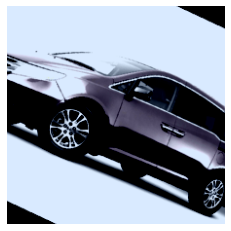

In [ ]:
#inspecting the dataloaders on a random image 
from PIL import Image 
import matplotlib.pyplot as plt

img = (next(iter(train_dataloader_20_percent)))[0][0].numpy().transpose(1,2,0)
img = img / img.max()
plt.imshow(img)
plt.axis(False)
plt.show()

Looks good! 

##Train google_net on the 20% training data 

In [ ]:
from going_modular.going_modular import engine 

optimizer = torch.optim.Adam(
    params = google_net.parameters(), 
    lr = .001 
)

loss_fn = nn.CrossEntropyLoss(label_smoothing = .1)

stanford_cars_20_percent_google_net_results = engine.train(
    model = google_net,
    train_dataloader = train_dataloader_20_percent, 
    test_dataloader = test_dataloader_20_percent, 
    optimizer = optimizer, 
    loss_fn = loss_fn, 
    epochs = 8, 
    device = device
)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.5263 | train_acc: 0.0074 | test_loss: 5.2751 | test_acc: 0.0141
Epoch: 2 | train_loss: 5.1358 | train_acc: 0.0252 | test_loss: 5.1418 | test_acc: 0.0233
Epoch: 3 | train_loss: 4.9301 | train_acc: 0.0530 | test_loss: 5.0436 | test_acc: 0.0319
Epoch: 4 | train_loss: 4.7829 | train_acc: 0.0723 | test_loss: 4.9122 | test_acc: 0.0613
Epoch: 5 | train_loss: 4.6438 | train_acc: 0.0965 | test_loss: 4.8512 | test_acc: 0.0570
Epoch: 6 | train_loss: 4.4949 | train_acc: 0.1248 | test_loss: 4.7905 | test_acc: 0.0699
Epoch: 7 | train_loss: 4.3686 | train_acc: 0.1615 | test_loss: 4.7575 | test_acc: 0.0852
Epoch: 8 | train_loss: 4.2784 | train_acc: 0.1615 | test_loss: 4.6784 | test_acc: 0.0815


##Inspecting Loss Curves

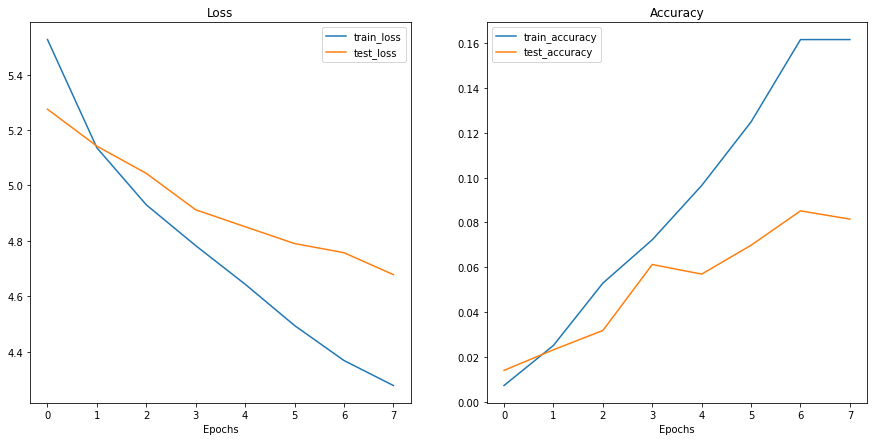

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(stanford_cars_20_percent_google_net_results)

This model massively overfits... let's try a smaller model... 
- ResNet has 11,689,512 parameters 
- googlenet has 6,624,904 parameters  
- Effnetb0 has 	 5,288,548 parameters 

Let's try effnetb2 


##Create EffNetB0 model

In [ ]:
from torchvision import models 

effnetb0_weights = models.EfficientNet_B0_Weights.DEFAULT
effnetb0_transforms = effnetb0_weights.transforms()
effnetb0 = torchvision.models.efficientnet_b0(weights = effnetb0_weights).to('cpu')



In [ ]:
next(effnetb0.parameters()).is_cuda 

False

In [ ]:
#check out the model 
#effnetb0

In [ ]:
#freeze params 
for param in effnetb0.parameters(): 
  param.requires_grad = False 
        
#change classifier 
effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=.2),
    nn.Linear(in_features = 1280, 
              out_features = 196)
)

In [ ]:
from torchvision import transforms 
#stanfordcars transform

stanford_cars_train_transforms_effnetb0 = transforms.Compose([
    transforms.TrivialAugmentWide(),
    #transforms.RandomCrop(50),
    transforms.RandomRotation(30),
    effnetb0_transforms]
)

In [ ]:
from pathlib import Path 
#Download data 

#create data path 
data_dir = Path('data')

train_data = torchvision.datasets.StanfordCars(
    root = data_dir,
     split = 'train', 
     transform = stanford_cars_train_transforms_effnetb0, 
     download = True)

test_data = torchvision.datasets.StanfordCars(
    root = data_dir,
     split = 'test', 
     transform = google_net_transforms, 
     download = True)

In [ ]:
#split the data into 20% chunks to speed up training in initial exploration

train_data_20_percent = torch.utils.data.Subset(train_data, range(0, int(.2*len(train_data))))
test_data_20_percent = torch.utils.data.Subset(test_data, range(0, int(.2*len(test_data))))

len(train_data_20_percent), len(test_data_20_percent)

(1628, 1608)

In [ ]:
#Create dataloader
from torch.utils.data import DataLoader
import os 

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() 

train_dataloader_20_percent = DataLoader(train_data_20_percent, 
                                         batch_size=BATCH_SIZE , 
                                         shuffle=True,
                                         num_workers=NUM_WORKERS )



test_dataloader_20_percent = DataLoader(test_data_20_percent, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False,
                                         num_workers=NUM_WORKERS )



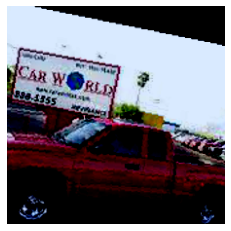

In [ ]:
#inspecting the dataloaders on a random image 
from PIL import Image 
import matplotlib.pyplot as plt

img = (next(iter(train_dataloader_20_percent)))[0][0].numpy().transpose(1,2,0)
img = img / img.max()
plt.imshow(img)
plt.axis(False)
plt.show()

In [ ]:
from going_modular.going_modular import engine 

optimizer = torch.optim.Adam(
    params = effnetb0.parameters(), 
    lr = .001 
)

loss_fn = nn.CrossEntropyLoss(label_smoothing = .1)

stanford_cars_20_percent_effnetb0_results = engine.train(
    model = effnetb0,
    train_dataloader = train_dataloader_20_percent, 
    test_dataloader = test_dataloader_20_percent, 
    optimizer = optimizer, 
    loss_fn = loss_fn, 
    epochs = 5, 
    device = device
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.3489 | train_acc: 0.0159 | test_loss: 5.1332 | test_acc: 0.0472
Epoch: 2 | train_loss: 4.6968 | train_acc: 0.1366 | test_loss: 4.9130 | test_acc: 0.0754
Epoch: 3 | train_loss: 4.3351 | train_acc: 0.2381 | test_loss: 4.7642 | test_acc: 0.0993
Epoch: 4 | train_loss: 4.0086 | train_acc: 0.3092 | test_loss: 4.6451 | test_acc: 0.1048
Epoch: 5 | train_loss: 3.7770 | train_acc: 0.3804 | test_loss: 4.5590 | test_acc: 0.1164


In [ ]:
next(effnetb0.parameters()).is_cuda 

False

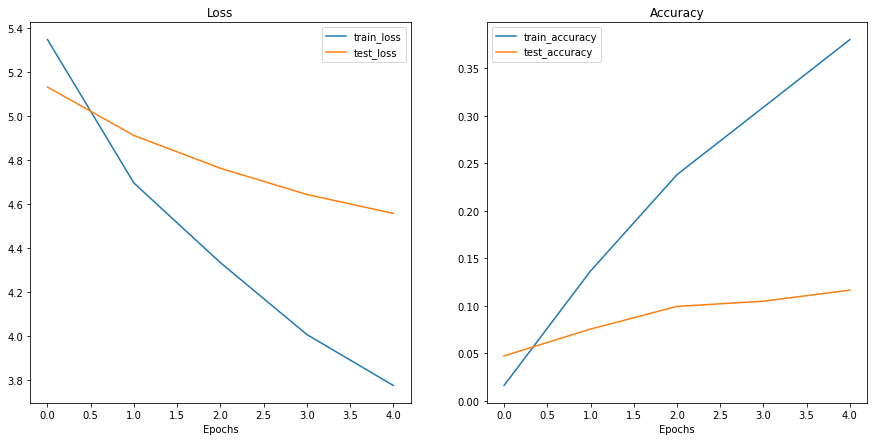

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(stanford_cars_20_percent_effnetb0_results)

##Save and Load the best model 
(Effnetb0) 

In [ ]:
#Save model 
from going_modular.going_modular import utils

utils.save_model(
    model = effnetb0, 
    target_dir = 'models', 
    model_name = 'pretrained_effnetb0_stanford_cars_20_percent.pth')

[INFO] Saving model to: models/pretrained_effnetb0_stanford_cars_20_percent.pth


In [ ]:
next(effnetb0.parameters()).is_cuda 

False

In [ ]:

next(effnetb0.parameters()).is_cuda 

False

In [ ]:
#make sure we can load the model back in 

loaded_effnetb0 = torchvision.models.efficientnet_b0()
loaded_effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=.2),
    nn.Linear(in_features = 1280, 
              out_features = 196)
)

loaded_effnetb0.load_state_dict(torch.load('models/pretrained_effnetb0_stanford_cars_20_percent.pth'))

FileNotFoundError: ignored

##Turning the model into a deployable app 

Launch on HuggingFace using Gradio

###Create demos directory 



In [ ]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
stanford_cars_demo_path = Path("demos/stanford_cars/")

# Remove files that might already exist there and create new directory
if stanford_cars_demo_path.exists():
    shutil.rmtree(stanford_cars_demo_path)
    stanford_cars_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    stanford_cars_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
# Check what's in the folder
!ls demos/stanford_cars_demo_path/

ls: cannot access 'demos/stanford_cars_demo_path/': No such file or directory


###Building examples directory 

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
stanford_cars_examples_path = stanford_cars_demo_path / "examples"
stanford_cars_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
stanford_cars_examples = [Path('data/stanford_cars/cars_test/00001.jpg'),
                            Path('data/stanford_cars/cars_test/00002.jpg'),
                            Path('data/stanford_cars/cars_test/00007.jpg')]

# 3. Copy the three random images to the examples directory
for example in stanford_cars_examples:
    destination = stanford_cars_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/stanford_cars/cars_test/00001.jpg to demos/stanford_cars/examples/00001.jpg
[INFO] Copying data/stanford_cars/cars_test/00002.jpg to demos/stanford_cars/examples/00002.jpg
[INFO] Copying data/stanford_cars/cars_test/00007.jpg to demos/stanford_cars/examples/00007.jpg


In [ ]:
#verify our examples are present

import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(stanford_cars_examples_path)]
example_list


[['examples/00002.jpg'], ['examples/00007.jpg'], ['examples/00001.jpg']]

###Moving our model to demos/models 

In [ ]:
import shutil

# Create a source path for our target model
effnetb0_stanford_cars_model_path = "models/pretrained_effnetb0_stanford_cars_20_percent.pth"

# Create a destination path for our target model 
effnetb0_stanford_cars_model_destination = stanford_cars_demo_path / effnetb0_stanford_cars_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb0_stanford_cars_model_path} to {effnetb0_stanford_cars_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb0_stanford_cars_model_path, 
                dst=effnetb0_stanford_cars_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb0_stanford_cars_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb0_stanford_cars_model_destination}: {effnetb0_stanford_cars_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb0_stanford_cars_20_percent.pth to demos/stanford_cars/pretrained_effnetb0_stanford_cars_20_percent.pth
[INFO] Model move complete.


###Building class_names.txt

In [ ]:
# Create path to Food101 class names
stanford_cars_class_names_path = stanford_cars_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(stanford_cars_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {stanford_cars_class_names_path}")
    f.write("\n".join(stanford_cars_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/stanford_cars/class_names.txt


In [ ]:
#make sure we can read them in 
with open(stanford_cars_class_names_path, "r") as f:
    stanford_cars_class_names_loaded = [car.strip() for car in  f.readlines()]
    
# View the first 5 class names loaded back in
stanford_cars_class_names_loaded[:5]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012']

###Building Model.py (turning our effnetb0 model into a python script) 


In [ ]:
%%writefile demos/stanford_cars/model.py
import torch
import torchvision

from torch import nn


def create_effnetb0(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b0(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/stanford_cars/model.py


###Building App.py

- Imports and class name function 
- Model and transforms preparation 
- Predict function 
- Gradio app 


In [ ]:
#%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb0_model
from timeit import default_timer as timer
from typing import Tuple, Dict


#class names 
with open('class_names.txt', "r") as f:
    class_names  = [car.strip() for car in  f.readlines()]
    
### 2. Model and transforms preparation ###    

# Create model
effnetb2, effnetb2_transforms = create_effnetb0(
    num_classes=196, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb0_stanford_cars_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Effnet Car Classifier 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of cars into [196 different classes]"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


FileNotFoundError: ignored

In [ ]:
%%writefile demos/stanford_cars/app.py
import gradio as gr 
import torchvision 
from torch import nn 


import torch

from timeit import default_timer as timer
from typing import Tuple, Dict

#class names 
with open('class_names.txt', "r") as f:
    class_names  = [car.strip() for car in  f.readlines()]


#model and transforms preparation
effnetb0_weights = models.EfficientNet_B0_Weights.DEFAULT
effnetb0 = torchvision.models.efficientnet_b0(weights = effnetb0_weights)
effnetb0_transforms = effnetb0_weights.transforms()

#freeze params 
for param in effnetb0.parameters(): 
  param.requires_grad = False 
        
#change classifier 
effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=.2),
    nn.Linear(in_features = 1280, 
              out_features = 196)
)

#load saved weights 
effnetb0.load_state_dict(torch.load('pretrained_effnetb0_stanford_cars_20_percent.pth'), 
                          map_location=torch.device("cpu"))


#predict function 

def predict(img) -> Tuple[Dict, float]:

  start_time = timer()

  #put model into eval mode 
  effnetb0.eval()

  with torch.inference_mode():
    pred_logits = effnetb0(img.unsqueeze(0))
    pred_probs = torch.softmax(pred_logits, dim = 1)

   # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  end_time = timer()

  time = round(end_time - start_time, 5) 

  return pred_labels_and_probs, time


#gradio app 

title = 'effnetb0'
description = 'Pretrained effnetb0 model on stanford cars dataset'

#create example list 
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description
    
)

# Launch the app!
demo.launch()




Writing demos/stanford_cars/app.py


In [ ]:
next

<function next>

###Building requriements.txt

In [ ]:
%%writefile demos/stanford_cars/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/stanford_cars/requirements.txt


###Download files as zip files

In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/stanford_cars && zip -r ../stanford_cars.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped Stanford_cars Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/stanford_cars.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

updating: app.py (deflated 53%)
updating: class_names.txt (deflated 68%)
updating: examples/ (stored 0%)
updating: examples/00002.jpg (deflated 0%)
updating: examples/00007.jpg (deflated 1%)
updating: examples/00001.jpg (deflated 6%)
updating: pretrained_effnetb0_stanford_cars_20_percent.pth (deflated 8%)
  adding: model.py (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
next(effnetb0.parameters()).is_cuda

False